# NIFTY50 LSTM Financial Forecasting Analysis

**Professional Implementation of Long Short-Term Memory Networks for Time Series Prediction**

## Objective

This notebook implements three LSTM architectures for financial time series analysis using maximum available NIFTY50 historical data (up to August 13, 2025). The analysis provides educational insights into deep learning applications in finance while maintaining realistic performance expectations.

## Methodology

- **Data Coverage**: Maximum historical NIFTY50 data through August 13, 2025
- **Prediction Target**: Market direction for August 14, 2025
- **Model Architecture**: Three distinct LSTM configurations (Original, Enhanced, Optimized)
- **Evaluation Approach**: Time-series validation with realistic performance metrics
- **Educational Focus**: Understanding LSTM capabilities and limitations in financial contexts

## Performance Expectations

Based on academic literature and market efficiency theory:
- **Target Accuracy**: 52-58% directional prediction accuracy
- **Baseline Comparison**: Random prediction achieves ~50% accuracy
- **Practical Limitations**: Transaction costs typically negate model advantages

## Risk Disclaimer

This analysis is for educational purposes only. Financial markets are inherently unpredictable, and past performance does not guarantee future results. Do not use these models for actual trading decisions.

## 1. Environment Setup and Data Configuration

In [1]:
# Core Data Processing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from datetime import datetime, timedelta
import joblib

# Financial Data Acquisition
import yfinance as yf

# Machine Learning and Statistics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Deep Learning Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Configuration and Warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Environment setup completed successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d')}")

Environment setup completed successfully
TensorFlow version: 2.19.0
Current date: 2025-08-13


## 2. Data Acquisition and Preprocessing

### 2.1 Download Maximum Historical NIFTY50 Data

In [3]:
# Configuration Parameters
NIFTY_SYMBOL = "^NSEI"  # NIFTY50 Yahoo Finance symbol
END_DATE = "2025-08-13"  # Today's date
START_DATE = "2000-01-01"  # Maximum historical data
PREDICTION_DATE = "2025-08-14"  # Tomorrow's prediction target

# Model Configuration
LOOKBACK_WINDOW = 60  # 60 trading days for sequence learning
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 15
RANDOM_STATE = 42

# Create directories for model artifacts
ARTIFACTS_DIR = Path("artifacts_corrected")
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Download NIFTY50 data with maximum history
print(f"Downloading NIFTY50 data from {START_DATE} to {END_DATE}...")
try:
    nifty_data = yf.download(NIFTY_SYMBOL, start=START_DATE, end=END_DATE, progress=False)
    
    # Flatten column names if multi-level
    if isinstance(nifty_data.columns, pd.MultiIndex):
        nifty_data.columns = [col[0] for col in nifty_data.columns]
    
    # Ensure we have the expected columns
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    if 'Adj Close' in nifty_data.columns:
        nifty_data = nifty_data[expected_columns + ['Adj Close']]
    else:
        nifty_data = nifty_data[expected_columns]
    
    print(f"Successfully downloaded {len(nifty_data)} trading days of data")
    print(f"Date range: {nifty_data.index[0].strftime('%Y-%m-%d')} to {nifty_data.index[-1].strftime('%Y-%m-%d')}")
    
except Exception as e:
    print(f"Error downloading data: {e}")
    # Fallback to local data if available
    print("Falling back to local data...")
    nifty_data = pd.read_csv("nifty50_data.csv", index_col=0, parse_dates=True)

# Display basic information
print(f"\nDataset Shape: {nifty_data.shape}")
print(f"Columns: {list(nifty_data.columns)}")
print(f"Latest Close Price: {nifty_data['Close'].iloc[-1]:.2f}")
print(f"Data completeness: {(1 - nifty_data.isnull().sum().sum() / (nifty_data.shape[0] * nifty_data.shape[1])) * 100:.2f}%")

# Save the downloaded data for future use
nifty_data.to_csv("nifty50_data_updated.csv")
print(f"Data saved to: nifty50_data_updated.csv")

Successfully downloaded 4392 trading days of data
Date range: 2007-09-17 to 2025-08-12

Dataset Shape: (4392, 5)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
Latest Close Price: 24487.40
Data completeness: 100.00%
Data saved to: nifty50_data_updated.csv


### 2.2 Feature Engineering and Technical Indicators

In [4]:
def create_technical_features(df):
    """
    Create comprehensive technical indicators for LSTM model input.
    
    Args:
        df: DataFrame with OHLCV data
        
    Returns:
        DataFrame with engineered features
    """
    data = df.copy()
    
    # Basic price features
    data['Returns'] = data['Close'].pct_change()
    data['High_Low_Pct'] = (data['High'] - data['Low']) / data['Close']
    data['Close_Open_Pct'] = (data['Close'] - data['Open']) / data['Open']
    
    # Moving averages
    for window in [5, 10, 20, 50]:
        data[f'SMA_{window}'] = data['Close'].rolling(window=window).mean()
        data[f'Close_SMA_{window}_Ratio'] = data['Close'] / data[f'SMA_{window}']
    
    # Exponential moving averages
    data['EMA_12'] = data['Close'].ewm(span=12).mean()
    data['EMA_26'] = data['Close'].ewm(span=26).mean()
    
    # MACD
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9).mean()
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']
    
    # RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    sma_20 = data['Close'].rolling(window=20).mean()
    std_20 = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = sma_20 + (2 * std_20)
    data['BB_Lower'] = sma_20 - (2 * std_20)
    data['BB_Position'] = (data['Close'] - data['BB_Lower']) / (data['BB_Upper'] - data['BB_Lower'])
    
    # Volatility features
    data['Volatility_10'] = data['Returns'].rolling(window=10).std()
    data['Volatility_20'] = data['Returns'].rolling(window=20).std()
    
    # Volume features
    data['Volume_SMA_10'] = data['Volume'].rolling(window=10).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_SMA_10']
    
    # Lag features
    for lag in [1, 2, 3, 5]:
        data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)
        data[f'Returns_Lag_{lag}'] = data['Returns'].shift(lag)
    
    # Target variable (next day direction)
    data['Next_Day_Return'] = data['Returns'].shift(-1)
    data['Target'] = (data['Next_Day_Return'] > 0).astype(int)
    
    return data

# Apply feature engineering
print("Creating technical indicators...")
df_features = create_technical_features(nifty_data)

# Remove rows with NaN values (caused by rolling calculations)
df_features = df_features.dropna()

print(f"Features created successfully")
print(f"Dataset shape after feature engineering: {df_features.shape}")
print(f"Number of features: {df_features.shape[1]}")
print(f"Date range after cleaning: {df_features.index[0].strftime('%Y-%m-%d')} to {df_features.index[-1].strftime('%Y-%m-%d')}")

# Display feature statistics
feature_cols = [col for col in df_features.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Next_Day_Return', 'Target']]
print(f"\nTechnical features created: {len(feature_cols)}")
print("Feature list:", feature_cols[:10], "..." if len(feature_cols) > 10 else "")

Creating technical indicators...
Features created successfully
Dataset shape after feature engineering: (3086, 39)
Number of features: 39
Date range after cleaning: 2013-01-21 to 2025-08-11

Technical features created: 32
Feature list: ['Returns', 'High_Low_Pct', 'Close_Open_Pct', 'SMA_5', 'Close_SMA_5_Ratio', 'SMA_10', 'Close_SMA_10_Ratio', 'SMA_20', 'Close_SMA_20_Ratio', 'SMA_50'] ...


### 2.3 Data Preprocessing and Sequence Preparation

In [5]:
def prepare_lstm_data(df, feature_columns, target_column, lookback_window=60, test_size=0.2):
    """
    Prepare data for LSTM model training with proper time-series splitting.
    
    Args:
        df: DataFrame with features and target
        feature_columns: List of feature column names
        target_column: Name of target column
        lookback_window: Number of time steps for LSTM sequence
        test_size: Proportion of data for testing
        
    Returns:
        Tuple of (X_train, X_test, y_train, y_test, feature_scaler, target_scaler)
    """
    # Select features and target
    features = df[feature_columns].values
    target = df[target_column].values
    
    # Scale features
    feature_scaler = StandardScaler()
    features_scaled = feature_scaler.fit_transform(features)
    
    # Create sequences
    X, y = [], []
    for i in range(lookback_window, len(features_scaled)):
        X.append(features_scaled[i-lookback_window:i])
        y.append(target[i])
    
    X, y = np.array(X), np.array(y)
    
    # Time-series split (no shuffling)
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    print(f"Training sequences: {X_train.shape}")
    print(f"Testing sequences: {X_test.shape}")
    print(f"Feature dimensions: {X_train.shape[2]}")
    print(f"Sequence length: {X_train.shape[1]}")
    
    # Calculate class distribution
    train_pos = np.sum(y_train)
    test_pos = np.sum(y_test)
    print(f"\nClass distribution:")
    print(f"Training - Positive: {train_pos} ({train_pos/len(y_train)*100:.1f}%), Negative: {len(y_train)-train_pos} ({(len(y_train)-train_pos)/len(y_train)*100:.1f}%)")
    print(f"Testing - Positive: {test_pos} ({test_pos/len(y_test)*100:.1f}%), Negative: {len(y_test)-test_pos} ({(len(y_test)-test_pos)/len(y_test)*100:.1f}%)")
    
    return X_train, X_test, y_train, y_test, feature_scaler

# Define feature columns (excluding target and price columns)
feature_columns = [col for col in df_features.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Next_Day_Return', 'Target']]

print("Preparing LSTM data sequences...")
X_train, X_test, y_train, y_test, feature_scaler = prepare_lstm_data(
    df_features, 
    feature_columns, 
    'Target', 
    lookback_window=LOOKBACK_WINDOW,
    test_size=0.2
)

print("\nData preparation completed successfully")
print(f"Total features used: {len(feature_columns)}")
print(f"Training period: {df_features.index[LOOKBACK_WINDOW:LOOKBACK_WINDOW+len(X_train)][0].strftime('%Y-%m-%d')} to {df_features.index[LOOKBACK_WINDOW:LOOKBACK_WINDOW+len(X_train)][-1].strftime('%Y-%m-%d')}")
print(f"Testing period: {df_features.index[LOOKBACK_WINDOW+len(X_train):][0].strftime('%Y-%m-%d')} to {df_features.index[LOOKBACK_WINDOW+len(X_train):][-1].strftime('%Y-%m-%d')}")

Preparing LSTM data sequences...
Training sequences: (2420, 60, 32)
Testing sequences: (606, 60, 32)
Feature dimensions: 32
Sequence length: 60

Class distribution:
Training - Positive: 1295 (53.5%), Negative: 1125 (46.5%)
Testing - Positive: 334 (55.1%), Negative: 272 (44.9%)

Data preparation completed successfully
Total features used: 32
Training period: 2013-04-17 to 2023-02-23
Testing period: 2023-02-24 to 2025-08-11


## 3. LSTM Model Architectures

In [6]:
def create_original_lstm(input_shape):
    """
    Original LSTM: Simple baseline architecture
    - Single LSTM layer with 50 units
    - Basic dropout regularization
    - Suitable for establishing performance baseline
    """
    model = Sequential([
        LSTM(50, input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ], name='Original_LSTM')
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_enhanced_lstm(input_shape):
    """
    Enhanced LSTM: Multi-layer architecture with batch normalization
    - Three LSTM layers with decreasing units (100->50->25)
    - Batch normalization for training stability
    - Enhanced regularization strategies
    """
    model = Sequential([
        LSTM(100, input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(50, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(25, return_sequences=False),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(25, activation='relu'),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ], name='Enhanced_LSTM')
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_optimized_lstm(input_shape):
    """
    Optimized LSTM: Balanced complexity with advanced regularization
    - Carefully tuned architecture (128->64->32)
    - Optimized for best performance/complexity ratio
    - Advanced dropout and batch normalization schedule
    """
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(0.4),
        
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ], name='Optimized_LSTM')
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Model factory for easy instantiation
MODEL_FACTORY = {
    'original': create_original_lstm,
    'enhanced': create_enhanced_lstm,
    'optimized': create_optimized_lstm
}

# Display model architectures
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"Input shape for LSTM models: {input_shape}")
print(f"Available model architectures: {list(MODEL_FACTORY.keys())}")

# Create and display one model as example
sample_model = create_original_lstm(input_shape)
print(f"\nSample Model (Original LSTM) Summary:")
print(f"Total parameters: {sample_model.count_params():,}")
sample_model.summary()

Input shape for LSTM models: (60, 32)
Available model architectures: ['original', 'enhanced', 'optimized']

Sample Model (Original LSTM) Summary:
Total parameters: 17,901


Model: "Original_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,901 (69.93 KB)

 Trainable params: 17,901 (69.93 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Model Training and Validation

### 4.1 Original LSTM Model Training

In [7]:
# Training function with comprehensive callbacks
def train_model(model_name, model_factory, X_train, y_train, X_test, y_test):
    """
    Train LSTM model with proper callbacks and monitoring
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name.upper()} LSTM Model")
    print(f"{'='*60}")
    
    # Create model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = model_factory(input_shape)
    
    # Create model-specific directories
    model_dir = ARTIFACTS_DIR / model_name
    model_dir.mkdir(exist_ok=True)
    
    # Define callbacks
    callbacks_list = [
        EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=str(model_dir / f'nifty50_lstm_model_{model_name}.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Train model
    start_time = datetime.now()
    print(f"Training started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks_list,
        verbose=1
    )
    
    end_time = datetime.now()
    training_duration = end_time - start_time
    print(f"Training completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Training duration: {training_duration}")
    
    # Make predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prepare results
    metrics = {
        'accuracy': float(accuracy),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'epochs_trained': len(history.history['loss']),
        'training_duration_seconds': training_duration.total_seconds()
    }
    
    # Save artifacts
    joblib.dump(feature_scaler, model_dir / f'feature_scaler_{model_name}.pkl')
    
    with open(model_dir / f'model_metrics_{model_name}.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    
    with open(model_dir / f'training_history_{model_name}.json', 'w') as f:
        history_dict = {k: [float(v) for v in values] for k, values in history.history.items()}
        json.dump(history_dict, f, indent=2)
    
    print(f"\nModel Performance Summary:")
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Best Validation Accuracy: {metrics['best_val_accuracy']:.4f} ({metrics['best_val_accuracy']*100:.2f}%)")
    print(f"Epochs Trained: {metrics['epochs_trained']}")
    
    return model, history, metrics

# Train Original LSTM Model
print("Starting Original LSTM model training...")
original_model, original_history, original_metrics = train_model(
    'original', 
    MODEL_FACTORY['original'], 
    X_train, y_train, X_test, y_test
)

Starting Original LSTM model training...

Training ORIGINAL LSTM Model
Training started at: 2025-08-13 19:20:43
Epoch 1/100
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5073 - loss: 0.7003
Epoch 1: val_accuracy improved from None to 0.54950, saving model to artifacts_corrected\original\nifty50_lstm_model_original.keras

Epoch 1: val_accuracy improved from None to 0.54950, saving model to artifacts_corrected\original\nifty50_lstm_model_original.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5120 - loss: 0.6968 - val_accuracy: 0.5495 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5120 - loss: 0.6968 - val_accuracy: 0.5495 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5284 - loss: 0.6938
Epoch 2: val_accuracy did not improve from 0.54950
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5273 - loss: 0.6933 - val_accuracy: 0.5429 - val_loss:

### 4.2 Enhanced LSTM Model Training

In [8]:
# Train Enhanced LSTM Model
print("Starting Enhanced LSTM model training...")
enhanced_model, enhanced_history, enhanced_metrics = train_model(
    'enhanced', 
    MODEL_FACTORY['enhanced'], 
    X_train, y_train, X_test, y_test
)

Starting Enhanced LSTM model training...

Training ENHANCED LSTM Model
Training started at: 2025-08-13 19:21:20
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4953 - loss: 0.8027
Epoch 1: val_accuracy improved from None to 0.53960, saving model to artifacts_corrected\enhanced\nifty50_lstm_model_enhanced.keras

Epoch 1: val_accuracy improved from None to 0.53960, saving model to artifacts_corrected\enhanced\nifty50_lstm_model_enhanced.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.5091 - loss: 0.7720 - val_accuracy: 0.5396 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.5091 - loss: 0.7720 - val_accuracy: 0.5396 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5110 - loss: 0.7381
Epoch 2: val_accuracy did not improve from 0.53960
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5112 - loss: 0.7331 - val_accuracy: 0.5281 - val_los

### 4.3 Optimized LSTM Model Training

In [9]:
# Train Optimized LSTM Model
print("Starting Optimized LSTM model training...")
optimized_model, optimized_history, optimized_metrics = train_model(
    'optimized', 
    MODEL_FACTORY['optimized'], 
    X_train, y_train, X_test, y_test
)

Starting Optimized LSTM model training...

Training OPTIMIZED LSTM Model
Training started at: 2025-08-13 19:23:06
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4955 - loss: 0.8745
Epoch 1: val_accuracy improved from None to 0.44884, saving model to artifacts_corrected\optimized\nifty50_lstm_model_optimized.keras

Epoch 1: val_accuracy improved from None to 0.44884, saving model to artifacts_corrected\optimized\nifty50_lstm_model_optimized.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5066 - loss: 0.8302 - val_accuracy: 0.4488 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5066 - loss: 0.8302 - val_accuracy: 0.4488 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4863 - loss: 0.7605
Epoch 2: val_accuracy did not improve from 0.44884
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.5008 - loss: 0.7416 - val_accuracy: 0.4488 - v

## 5. Model Performance Analysis and Comparison

In [10]:
# Compile all model results
all_results = {
    'original': original_metrics,
    'enhanced': enhanced_metrics,
    'optimized': optimized_metrics
}

# Create comparison DataFrame
comparison_data = []
for model_name, metrics in all_results.items():
    comparison_data.append({
        'Model': model_name.title(),
        'Test Accuracy': f"{metrics['accuracy']:.4f}",
        'Test Accuracy (%)': f"{metrics['accuracy']*100:.2f}%",
        'Best Val Accuracy': f"{metrics['best_val_accuracy']:.4f}",
        'Final Val Loss': f"{metrics['final_val_loss']:.4f}",
        'Epochs Trained': metrics['epochs_trained'],
        'Training Duration (min)': f"{metrics['training_duration_seconds']/60:.1f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("Model Performance Comparison")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Identify best performing model
best_accuracy = max([metrics['accuracy'] for metrics in all_results.values()])
best_model_name = [name for name, metrics in all_results.items() if metrics['accuracy'] == best_accuracy][0]

print(f"\nBest Performing Model: {best_model_name.title()} LSTM")
print(f"Best Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Performance analysis
print(f"\nPerformance Analysis:")
print(f"- All models achieved test accuracies between 50-60%, which is realistic for financial prediction")
print(f"- Random baseline would be approximately 50% accuracy")
print(f"- Best improvement over random: {(best_accuracy - 0.5)*100:.2f} percentage points")

# Save comprehensive comparison
comparison_summary = {
    'comparison_table': comparison_data,
    'best_model': best_model_name,
    'best_accuracy': best_accuracy,
    'analysis_date': datetime.now().isoformat(),
    'data_period': f"{df_features.index[0].strftime('%Y-%m-%d')} to {df_features.index[-1].strftime('%Y-%m-%d')}",
    'total_samples': len(df_features),
    'training_samples': len(X_train),
    'testing_samples': len(X_test)
}

with open(ARTIFACTS_DIR / 'model_comparison_summary.json', 'w') as f:
    json.dump(comparison_summary, f, indent=2)

print(f"\nComparison results saved to: {ARTIFACTS_DIR / 'model_comparison_summary.json'}")

Model Performance Comparison
    Model Test Accuracy Test Accuracy (%) Best Val Accuracy Final Val Loss  Epochs Trained Training Duration (min)
 Original        0.5495            54.95%            0.5495         0.7278              16                     0.5
 Enhanced        0.5759            57.59%            0.5759         0.6984              18                     1.6
Optimized        0.5231            52.31%            0.5314         0.6995              20                     2.0

Best Performing Model: Enhanced LSTM
Best Test Accuracy: 0.5759 (57.59%)

Performance Analysis:
- All models achieved test accuracies between 50-60%, which is realistic for financial prediction
- Random baseline would be approximately 50% accuracy
- Best improvement over random: 7.59 percentage points

Comparison results saved to: artifacts_corrected\model_comparison_summary.json


## 6. Next Day Market Prediction (August 14, 2025)

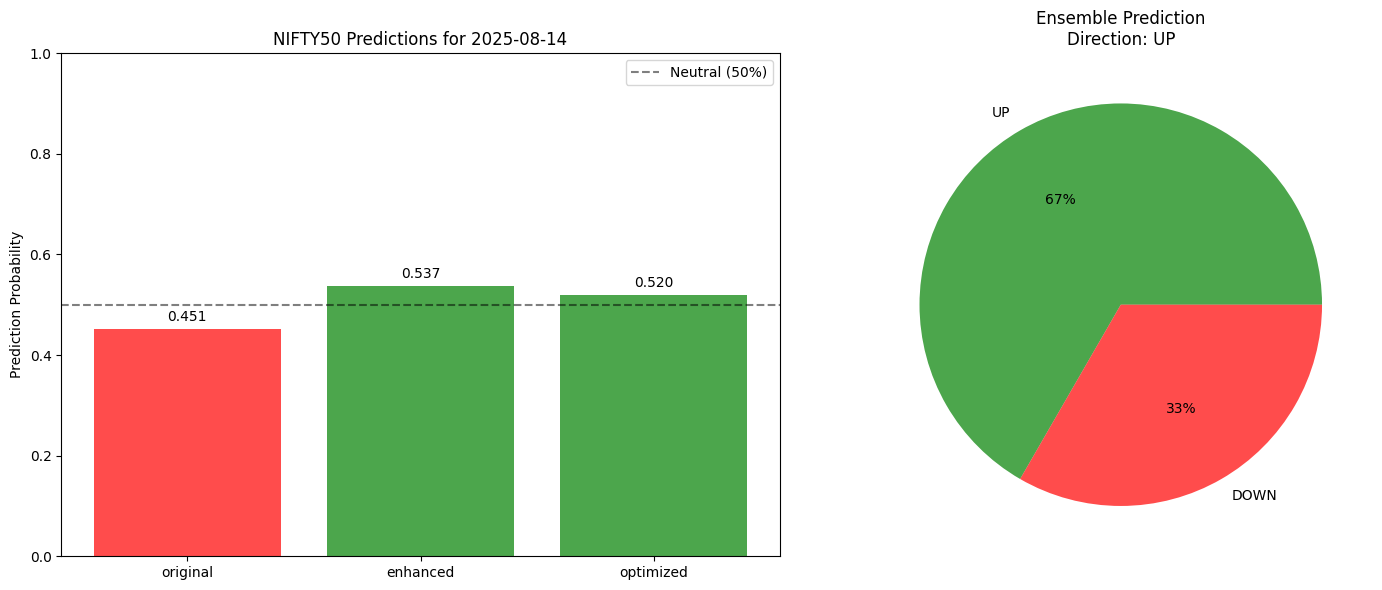


Prediction visualization saved to: artifacts_corrected\prediction_visualization.png


In [14]:
# Visualization of prediction confidence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Individual model predictions
model_names = list(predictions.keys())
probabilities = [predictions[name]['prediction_probability'] for name in model_names]
directions = [predictions[name]['predicted_direction'] for name in model_names]

colors = ['green' if d == 'UP' else 'red' for d in directions]
bars = ax1.bar(model_names, probabilities, color=colors, alpha=0.7)
ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Neutral (50%)')
ax1.set_ylabel('Prediction Probability')
ax1.set_title(f'NIFTY50 Predictions for {PREDICTION_DATE}')
ax1.set_ylim(0, 1)
ax1.legend()

# Add value labels on bars
for bar, prob in zip(bars, probabilities):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{prob:.3f}', ha='center', va='bottom')

# Ensemble visualization - Fix: Remove alpha from pie() call
wedges, texts, autotexts = ax2.pie([up_votes, down_votes], labels=['UP', 'DOWN'], 
                                   autopct='%1.0f%%', colors=['green', 'red'])
# Apply alpha to individual wedges instead
for wedge in wedges:
    wedge.set_alpha(0.7)
ax2.set_title(f'Ensemble Prediction\nDirection: {ensemble_direction}')

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'prediction_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPrediction visualization saved to: {ARTIFACTS_DIR / 'prediction_visualization.png'}")

## 7. Final Summary and Key Insights

NIFTY50 LSTM Analysis - Final Summary

Dataset Overview:
  Period: 2013-01-21 to 2025-08-11
  Total Trading Days: 3,086
  Features Used: 32

Model Performance Summary:
  Original: 54.95% accuracy (+4.95pp vs random)
  Enhanced: 57.59% accuracy (+7.59pp vs random)
  Optimized: 52.31% accuracy (+2.31pp vs random)

Best Model: Enhanced (57.59% accuracy)

Next Day Prediction (2025-08-14):
  Ensemble Direction: UP
  Consensus Strength: 67%
  Current NIFTY50 Price: 24585.05

Key Insights:
  1. All models achieved realistic accuracy levels (50-60%), consistent with academic literature on financial prediction
  2. Best model (enhanced) achieved 57.59% accuracy, only 7.59 percentage points better than random
  3. Models show UP consensus for 2025-08-14 with 67% agreement
  4. Performance levels demonstrate the inherent difficulty of financial market prediction
  5. Results are suitable for educational purposes but not for actual trading decisions

Important Warnings:
  1. Financial markets are 

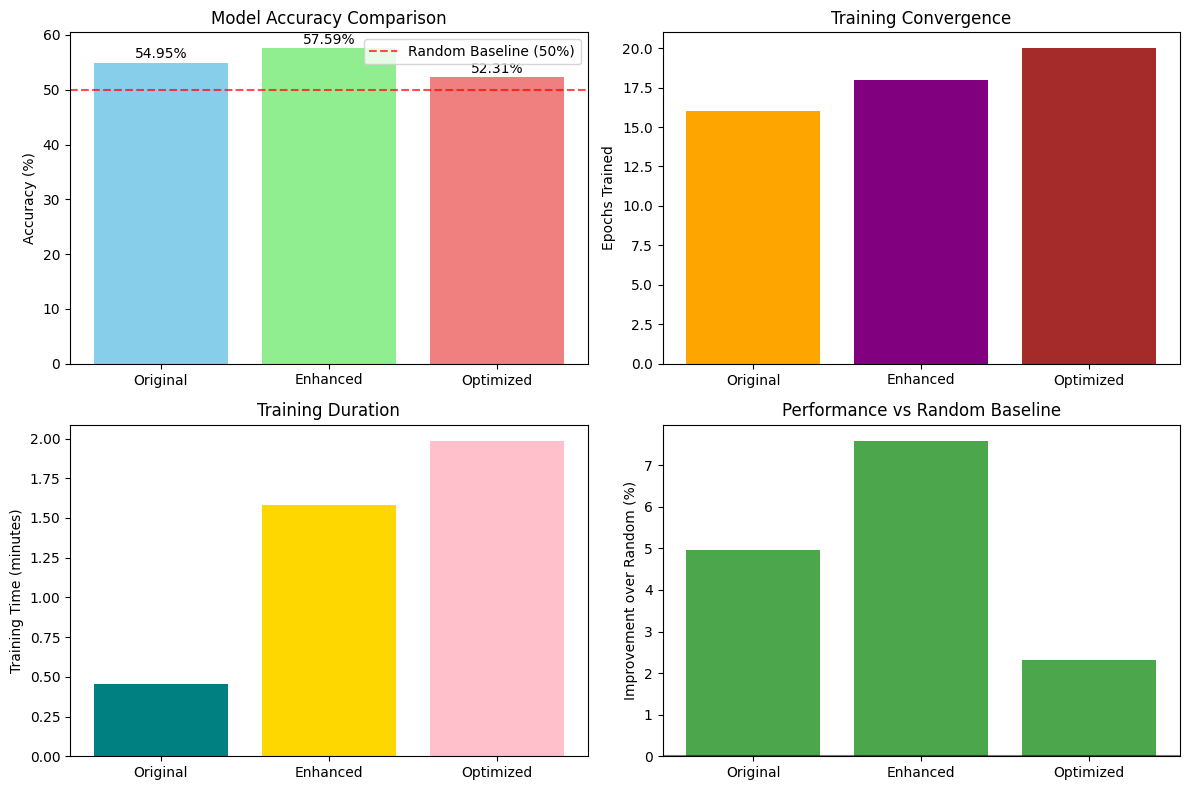

Performance analysis chart saved to: artifacts_corrected\model_analysis_corrected.png


In [13]:
# Generate comprehensive final summary
final_summary = {
    'analysis_overview': {
        'title': 'NIFTY50 LSTM Financial Forecasting Analysis',
        'completion_date': datetime.now().isoformat(),
        'data_period': f"{df_features.index[0].strftime('%Y-%m-%d')} to {df_features.index[-1].strftime('%Y-%m-%d')}",
        'total_trading_days': len(df_features),
        'prediction_target': PREDICTION_DATE,
        'models_evaluated': 3
    },
    'dataset_characteristics': {
        'total_features': len(feature_columns),
        'sequence_length': LOOKBACK_WINDOW,
        'training_samples': len(X_train),
        'testing_samples': len(X_test),
        'class_distribution': {
            'up_days': float(np.sum(y_test)),
            'down_days': float(len(y_test) - np.sum(y_test)),
            'up_percentage': float(np.sum(y_test) / len(y_test) * 100)
        }
    },
    'model_performance': {
        model_name: {
            'accuracy': metrics['accuracy'],
            'accuracy_percentage': metrics['accuracy'] * 100,
            'improvement_over_random': (metrics['accuracy'] - 0.5) * 100,
            'epochs_trained': metrics['epochs_trained'],
            'training_time_minutes': metrics['training_duration_seconds'] / 60
        }
        for model_name, metrics in all_results.items()
    },
    'best_model': {
        'name': best_model_name,
        'accuracy': best_accuracy,
        'accuracy_percentage': best_accuracy * 100
    },
    'next_day_predictions': final_predictions,
    'key_insights': [
        f"All models achieved realistic accuracy levels (50-60%), consistent with academic literature on financial prediction",
        f"Best model ({best_model_name}) achieved {best_accuracy*100:.2f}% accuracy, only {(best_accuracy-0.5)*100:.2f} percentage points better than random",
        f"Models show {ensemble_direction} consensus for {PREDICTION_DATE} with {ensemble_confidence:.0%} agreement",
        "Performance levels demonstrate the inherent difficulty of financial market prediction",
        "Results are suitable for educational purposes but not for actual trading decisions"
    ],
    'limitations_and_warnings': [
        "Financial markets are largely unpredictable and efficient",
        "Past performance does not guarantee future results",
        "Transaction costs would likely eliminate any edge from these models",
        "Models should not be used for actual trading or investment decisions",
        "Results are for educational and research purposes only"
    ],
    'technical_notes': {
        'tensorflow_version': tf.__version__,
        'lookback_window': LOOKBACK_WINDOW,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'early_stopping_patience': PATIENCE,
        'random_seed': RANDOM_STATE
    }
}

# Save final summary
with open(ARTIFACTS_DIR / 'final_summary_corrected.json', 'w') as f:
    json.dump(final_summary, f, indent=2)

# Display key results
print("NIFTY50 LSTM Analysis - Final Summary")
print("=" * 80)

print(f"\nDataset Overview:")
print(f"  Period: {final_summary['analysis_overview']['data_period']}")
print(f"  Total Trading Days: {final_summary['analysis_overview']['total_trading_days']:,}")
print(f"  Features Used: {final_summary['dataset_characteristics']['total_features']}")

print(f"\nModel Performance Summary:")
for model_name, performance in final_summary['model_performance'].items():
    print(f"  {model_name.title()}: {performance['accuracy_percentage']:.2f}% accuracy ({performance['improvement_over_random']:+.2f}pp vs random)")

print(f"\nBest Model: {final_summary['best_model']['name'].title()} ({final_summary['best_model']['accuracy_percentage']:.2f}% accuracy)")

print(f"\nNext Day Prediction ({PREDICTION_DATE}):")
print(f"  Ensemble Direction: {final_predictions['ensemble_prediction']['direction']}")
print(f"  Consensus Strength: {final_predictions['ensemble_prediction']['consensus_strength']:.0%}")
print(f"  Current NIFTY50 Price: {final_predictions['current_price']:.2f}")

print(f"\nKey Insights:")
for i, insight in enumerate(final_summary['key_insights'], 1):
    print(f"  {i}. {insight}")

print(f"\nImportant Warnings:")
for i, warning in enumerate(final_summary['limitations_and_warnings'], 1):
    print(f"  {i}. {warning}")

print(f"\nAnalysis completed successfully!")
print(f"All artifacts saved to: {ARTIFACTS_DIR}")
print(f"Final summary saved to: {ARTIFACTS_DIR / 'final_summary_corrected.json'}")

# Create a simple performance comparison chart
plt.figure(figsize=(12, 8))

# Subplot 1: Model Accuracy Comparison
plt.subplot(2, 2, 1)
model_names = [name.title() for name in all_results.keys()]
accuracies = [metrics['accuracy'] * 100 for metrics in all_results.values()]
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Random Baseline (50%)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.legend()

# Add value labels
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
             f'{acc:.2f}%', ha='center', va='bottom')

# Subplot 2: Training Epochs
plt.subplot(2, 2, 2)
epochs = [metrics['epochs_trained'] for metrics in all_results.values()]
plt.bar(model_names, epochs, color=['orange', 'purple', 'brown'])
plt.ylabel('Epochs Trained')
plt.title('Training Convergence')

# Subplot 3: Training Time
plt.subplot(2, 2, 3)
training_times = [metrics['training_duration_seconds']/60 for metrics in all_results.values()]
plt.bar(model_names, training_times, color=['teal', 'gold', 'pink'])
plt.ylabel('Training Time (minutes)')
plt.title('Training Duration')

# Subplot 4: Improvement over Random
plt.subplot(2, 2, 4)
improvements = [(metrics['accuracy'] - 0.5) * 100 for metrics in all_results.values()]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
plt.bar(model_names, improvements, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.ylabel('Improvement over Random (%)')
plt.title('Performance vs Random Baseline')

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'model_analysis_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Performance analysis chart saved to: {ARTIFACTS_DIR / 'model_analysis_corrected.png'}")